In [10]:
# 1. Import Library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier, early_stopping

# 2. Load Dataset Bersih
df = pd.read_csv("dtsen_clean_padangpanjang.csv")

print("Shape:", df.shape)
print("Target distribusi:\n", df['is_poor'].value_counts())


Shape: (1000, 42)
Target distribusi:
 is_poor
0    662
1    338
Name: count, dtype: int64


In [11]:
# Pilih fitur
cat_cols = [
    "kelurahan","kecamatan","status_kepemilikan_rumah",
    "pendidikan_kepala_keluarga","pekerjaan_kepala_keluarga",
    "status_perkawinan","penerima_bansos","jenis_bansos",
    "status_stunting","akses_fasilitas_kesehatan",
    "riwayat_penyakit_kronis","disabilitas"
]

num_cols = [
    "jumlah_anggota_keluarga","luas_lantai","jumlah_kamar_tidur",
    "jumlah_anak_balita","jumlah_anak_sekolah",
    "pengeluaran_per_bulan","pendapatan_per_bulan",
    "rasio_pengeluaran_pendapatan","kepadatan_rumah"
]

# Encode kategori dengan LabelEncoder
df_model = df.copy()
for c in cat_cols:
    df_model[c] = LabelEncoder().fit_transform(df_model[c].astype(str))

X = df_model[cat_cols + num_cols]
y = df_model["is_poor"]

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [14]:
from lightgbm import LGBMClassifier, early_stopping

model = LGBMClassifier(
    n_estimators=500,
    random_state=42,
    objective="binary",
    boosting_type="gbdt"
)

# Training dengan callback early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[early_stopping(stopping_rounds=50, verbose=True)]
)

# Prediksi
y_pred = model.predict_proba(X_test)[:,1]


[LightGBM] [Info] Number of positive: 270, number of negative: 530
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1187
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.337500 -> initscore=-0.674455
[LightGBM] [Info] Start training from score -0.674455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

AUC: 1.0

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       132
           1       1.00      1.00      1.00        68

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


--- Confusion Matrix ---
[[132   0]
 [  0  68]]


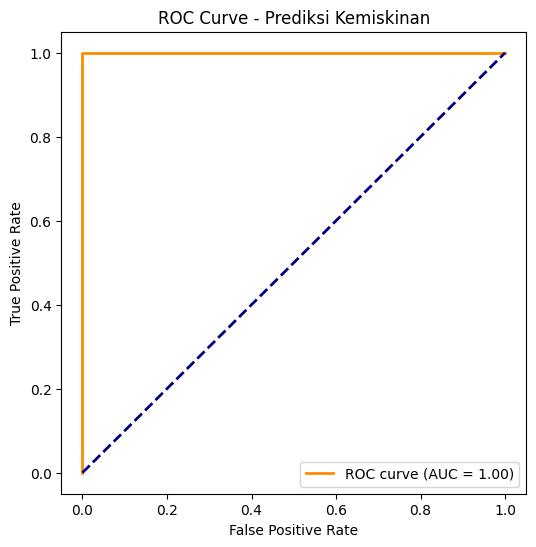

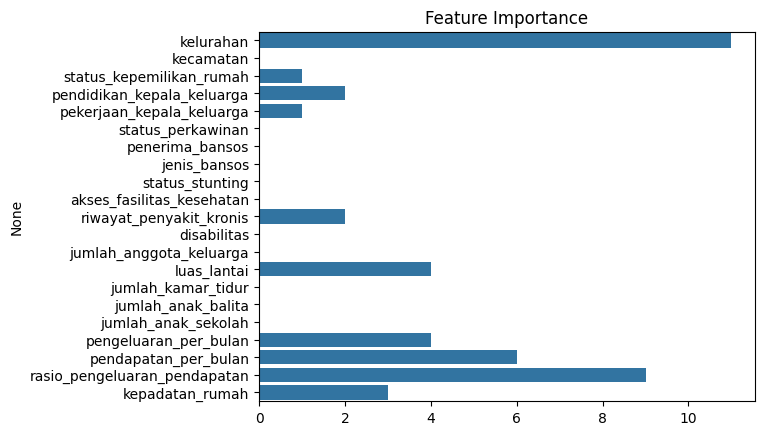

In [15]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung AUC
auc_score = roc_auc_score(y_test, y_pred)
print("AUC:", auc_score)

# Threshold 0.5 → konversi ke kelas
y_pred_label = (y_pred >= 0.5).astype(int)

# Report & confusion matrix
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_label))

print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred_label))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Prediksi Kemiskinan")
plt.legend(loc="lower right")
plt.show()

# Feature Importance
lgbm_importance = model.feature_importances_
features = X_train.columns
sns.barplot(x=lgbm_importance, y=features)
plt.title("Feature Importance")
plt.show()


In [16]:
df_scores = df.copy()
df_scores["risk_score"] = model.predict_proba(X)[:,1]

# Ranking top 20 keluarga paling rentan
df_scores_top = df_scores.sort_values("risk_score", ascending=False).head(20)
df_scores_top[["nik_kepala_keluarga","nama_kepala_keluarga","kelurahan","kecamatan","risk_score"]]


,nik_kepala_keluarga,nama_kepala_keluarga,kelurahan,kecamatan,risk_score
12,3201000000000012,Joko Hidayat,Koto Katiak,Padang Panjang Timur,0.569081
470,3201000000000470,Tono Wijaya,Pasar Baru,Padang Panjang Barat,0.569081
912,3201000000000912,Ayu Wijaya,Kampung Jambak,Padang Panjang Timur,0.569081
744,3201000000000744,Rina Hidayat,Ngalau,Padang Panjang Barat,0.569081
624,3201000000000624,Ayu Saputra,Balai-Balai,Padang Panjang Barat,0.569081
578,3201000000000578,Siti Hidayat,Ngalau,Padang Panjang Barat,0.569081
26,3201000000000026,Andi Saputra,Silaing Bawah,Padang Panjang Timur,0.568795
324,3201000000000324,Siti Hidayat,Silaing Bawah,Padang Panjang Timur,0.568795
530,3201000000000530,Ayu Wijaya,Silaing Bawah,Padang Panjang Timur,0.568795
665,3201000000000665,Joko Saputra,Silaing Bawah,Padang Panjang Timur,0.568795


# **02_Prediksi_Stunting_DTSEN**

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier, early_stopping

# Load dataset bersih
df = pd.read_csv("dtsen_clean_padangpanjang.csv")
print(df['status_stunting'].value_counts())


status_stunting
Tidak    548
Ya       452
Name: count, dtype: int64


In [18]:
# Encode target (Ya = 1, Tidak = 0)
df['status_stunting'] = df['status_stunting'].map({'Ya':1, 'Tidak':0})

# Pilih fitur relevan untuk stunting
cat_cols = [
    "pendidikan_kepala_keluarga",
    "akses_fasilitas_kesehatan",
    "riwayat_penyakit_kronis",
    "disabilitas"
]

num_cols = [
    "jumlah_anak_balita",
    "jumlah_anak_sekolah",
    "luas_lantai",
    "jumlah_anggota_keluarga",
    "rasio_pengeluaran_pendapatan",
    "kepadatan_rumah"
]

# Encode kategori
df_model = df.copy()
for c in cat_cols:
    df_model[c] = LabelEncoder().fit_transform(df_model[c].astype(str))

X = df_model[cat_cols + num_cols]
y = df_model["status_stunting"]

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [19]:
model = LGBMClassifier(
    n_estimators=500,
    random_state=42,
    objective="binary",
    boosting_type="gbdt"
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[early_stopping(stopping_rounds=50, verbose=True)]
)

y_pred = model.predict_proba(X_test)[:,1]


[LightGBM] [Info] Number of positive: 362, number of negative: 438
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452500 -> initscore=-0.190575
[LightGBM] [Info] Start training from score -0.190575
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

AUC: 0.5380808080808082

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.55      0.92      0.69       110
           1       0.50      0.10      0.17        90

    accuracy                           0.55       200
   macro avg       0.53      0.51      0.43       200
weighted avg       0.53      0.55      0.46       200


--- Confusion Matrix ---
[[101   9]
 [ 81   9]]


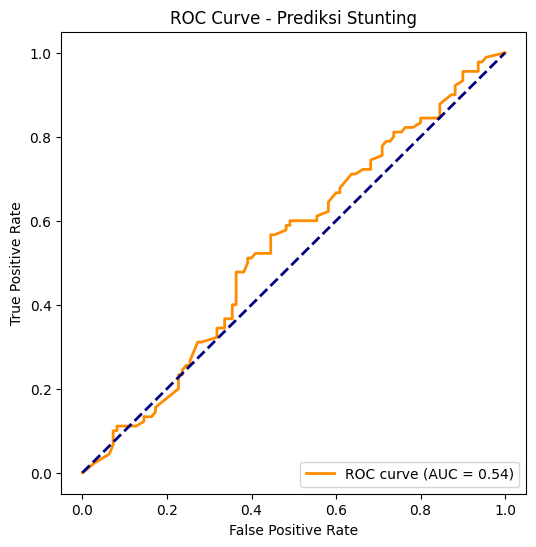

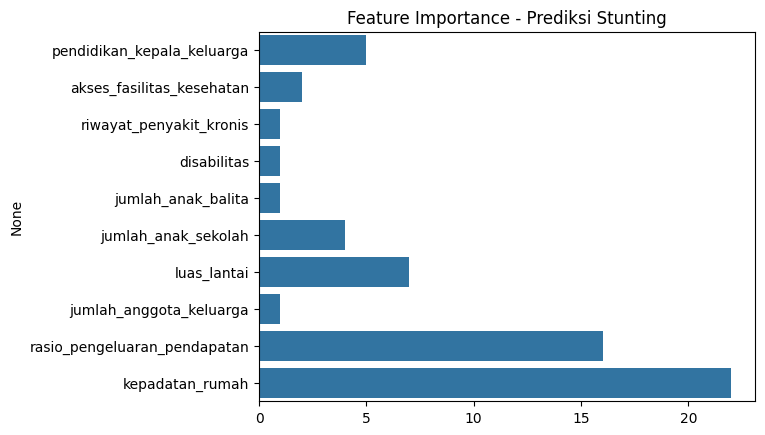

In [20]:
auc_score = roc_auc_score(y_test, y_pred)
print("AUC:", auc_score)

y_pred_label = (y_pred >= 0.5).astype(int)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_label))
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred_label))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Prediksi Stunting")
plt.legend(loc="lower right")
plt.show()

# Feature Importance
sns.barplot(x=model.feature_importances_, y=X_train.columns)
plt.title("Feature Importance - Prediksi Stunting")
plt.show()


**Tabel scoring per keluarga → setiap keluarga punya nilai risiko stunting (0–1).**

In [21]:
# Buat risk score (probabilitas stunting)
df_scores = df.copy()
df_scores["stunting_risk_score"] = model.predict_proba(X)[:,1]

# Preview 10 baris pertama
df_scores[["nik_kepala_keluarga","nama_kepala_keluarga","kelurahan","kecamatan","stunting_risk_score"]].head(10)


,nik_kepala_keluarga,nama_kepala_keluarga,kelurahan,kecamatan,stunting_risk_score
0,3201000000000000,Agus Santoso,Pasar Baru,Padang Panjang Barat,0.453937
1,3201000000000001,Andi Santoso,Guguk Malintang,Padang Panjang Timur,0.527469
2,3201000000000002,Dewi Hidayat,Guguk Malintang,Padang Panjang Timur,0.436735
3,3201000000000003,Tono Santoso,Bukit Surungan,Padang Panjang Barat,0.499655
4,3201000000000004,Joko Wijaya,Balai-Balai,Padang Panjang Barat,0.446164
5,3201000000000005,Budi Wijaya,Tanah Hitam,Padang Panjang Barat,0.442044
6,3201000000000006,Joko Saputra,Ngalau,Padang Panjang Barat,0.420092
7,3201000000000007,Rina Wijaya,Ekor Lubuk,Padang Panjang Barat,0.425976
8,3201000000000008,Joko Wijaya,Balai-Balai,Padang Panjang Barat,0.395726
9,3201000000000009,Joko Wijaya,Ekor Lubuk,Padang Panjang Barat,0.419856


from matplotlib import pyplot as plt
_df_0['nik_kepala_keluarga'].plot(kind='hist', bins=20, title='nik_kepala_keluarga')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['stunting_risk_score'].plot(kind='hist', bins=20, title='stunting_risk_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('nama_kepala_keluarga').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('kelurahan').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('kecamatan').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='nik_kepala_keluarga', y='stunting_risk_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['nik_kepala_keluarga']
  ys = series['stunting_risk_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('nik_kepala_keluarga', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('nama_kepala_keluarga')):
  _plot_series(series, series_name, i)
  fig.legend(title='nama_kepala_keluarga', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('nik_kepala_keluarga')
_ = plt.ylabel('stunting_risk_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['nik_kepala_keluarga']
  ys = series['stunting_risk_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('nik_kepala_keluarga', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('kelurahan')):
  _plot_series(series, series_name, i)
  fig.legend(title='kelurahan', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('nik_kepala_keluarga')
_ = plt.ylabel('stunting_risk_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['nik_kepala_keluarga']
  ys = series['stunting_risk_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('nik_kepala_keluarga', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('kecamatan')):
  _plot_series(series, series_name, i)
  fig.legend(title='kecamatan', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('nik_kepala_keluarga')
_ = plt.ylabel('stunting_risk_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['nik_kepala_keluarga']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'nik_kepala_keluarga'}, axis=1)
              .sort_values('nik_kepala_keluarga', ascending=True))
  xs = counted['nik_kepala_keluarga']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('nik_kepala_keluarga', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('nama_kepala_keluarga')):
  _plot_series(series, series_name, i)
  fig.legend(title='nama_kepala_keluarga', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('nik_kepala_keluarga')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_10['nik_kepala_keluarga'].plot(kind='line', figsize=(8, 4), title='nik_kepala_keluarga')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['stunting_risk_score'].plot(kind='line', figsize=(8, 4), title='stunting_risk_score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['kelurahan'].value_counts()
    for x_label, grp in _df_12.groupby('nama_kepala_keluarga')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('nama_kepala_keluarga')
_ = plt.ylabel('kelurahan')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['kecamatan'].value_counts()
    for x_label, grp in _df_13.groupby('kelurahan')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('kelurahan')
_ = plt.ylabel('kecamatan')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['nama_kepala_keluarga'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='nik_kepala_keluarga', y='nama_kepala_keluarga', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['kelurahan'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='nik_kepala_keluarga', y='kelurahan', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['kecamatan'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='nik_kepala_keluarga', y='kecamatan', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['nama_kepala_keluarga'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='stunting_risk_score', y='nama_kepala_keluarga', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [22]:
# Top 20 keluarga dengan risiko stunting tertinggi
df_top_stunting = df_scores.sort_values("stunting_risk_score", ascending=False).head(20)

df_top_stunting[[
    "nik_kepala_keluarga",
    "nama_kepala_keluarga",
    "kelurahan",
    "kecamatan",
    "stunting_risk_score"
]]


,nik_kepala_keluarga,nama_kepala_keluarga,kelurahan,kecamatan,stunting_risk_score
31,3201000000000031,Fitri Santoso,Silaing Bawah,Padang Panjang Timur,0.527469
897,3201000000000897,Ayu Wijaya,Kampung Jambak,Padang Panjang Timur,0.527469
918,3201000000000918,Tono Wijaya,Koto Katik,Padang Panjang Timur,0.527469
820,3201000000000820,Andi Santoso,Balai-Balai,Padang Panjang Barat,0.527469
804,3201000000000804,Tono Santoso,Silaing Atas,Padang Panjang Timur,0.527469
859,3201000000000859,Dewi Saputra,Balai-Balai,Padang Panjang Barat,0.527469
885,3201000000000885,Andi Hidayat,Kampung Jambak,Padang Panjang Timur,0.527469
794,3201000000000794,Tono Saputra,Koto Katiak,Padang Panjang Timur,0.527469
856,3201000000000856,Andi Santoso,Guguk Malintang,Padang Panjang Timur,0.527469
635,3201000000000635,Tono Saputra,Pasar Baru,Padang Panjang Barat,0.527469


**Agregasi per kelurahan → kelurahan mana yang punya risiko rata-rata tertinggi.**

In [23]:
risk_kelurahan = df_scores.groupby("kelurahan")["stunting_risk_score"].mean().reset_index()
risk_kelurahan = risk_kelurahan.sort_values("stunting_risk_score", ascending=False)
print(risk_kelurahan)


           kelurahan  stunting_risk_score
14       Tanah Hitam             0.465029
6        Koto Katiak             0.456976
8       Koto Panjang             0.456439
10        Pasar Baru             0.456050
4     Kampung Jambak             0.454135
1     Bukit Surungan             0.453781
3    Guguk Malintang             0.453182
2         Ekor Lubuk             0.452851
5    Kampung Manggis             0.452542
0        Balai-Balai             0.452028
11       Pasar Usang             0.451757
9             Ngalau             0.449012
12      Silaing Atas             0.448145
15  Tanah Pak Lambik             0.446580
7         Koto Katik             0.445707
13     Silaing Bawah             0.445509


**Visualisasi distribusi → gambaran umum risiko stunting di seluruh kota.**

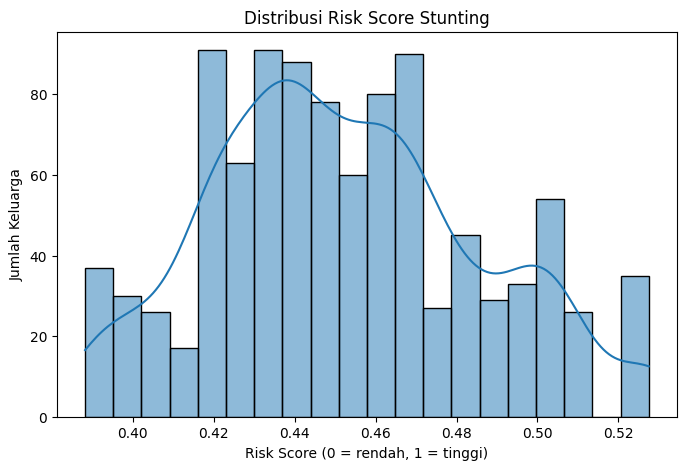

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(df_scores["stunting_risk_score"], bins=20, kde=True)
plt.title("Distribusi Risk Score Stunting")
plt.xlabel("Risk Score (0 = rendah, 1 = tinggi)")
plt.ylabel("Jumlah Keluarga")
plt.show()


**03_Clustering_Hunian_Kumuh_DTSEN**

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load data bersih
df = pd.read_csv("dtsen_clean_padangpanjang.csv")


*fitur*

In [26]:
features = [
    "status_kepemilikan_rumah",
    "jenis_lantai",
    "jenis_dinding",
    "jenis_atap",
    "luas_lantai",
    "jumlah_anggota_keluarga",
    "jumlah_kamar_tidur",
    "akses_air_minum",
    "fasilitas_buang_tinja"
]

# Encode kategori
df_cluster = df.copy()
for col in ["status_kepemilikan_rumah","jenis_lantai","jenis_dinding","jenis_atap","fasilitas_buang_tinja"]:
    df_cluster[col] = LabelEncoder().fit_transform(df_cluster[col].astype(str))

X = df_cluster[[
    "status_kepemilikan_rumah","jenis_lantai","jenis_dinding","jenis_atap",
    "luas_lantai","jumlah_anggota_keluarga","jumlah_kamar_tidur","fasilitas_buang_tinja"
]]


**Clustring**

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering (3 cluster → Layak Huni, Semi-Kumuh, Kumuh)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster["cluster"] = kmeans.fit_predict(X_scaled)


**Visualisai PCA**

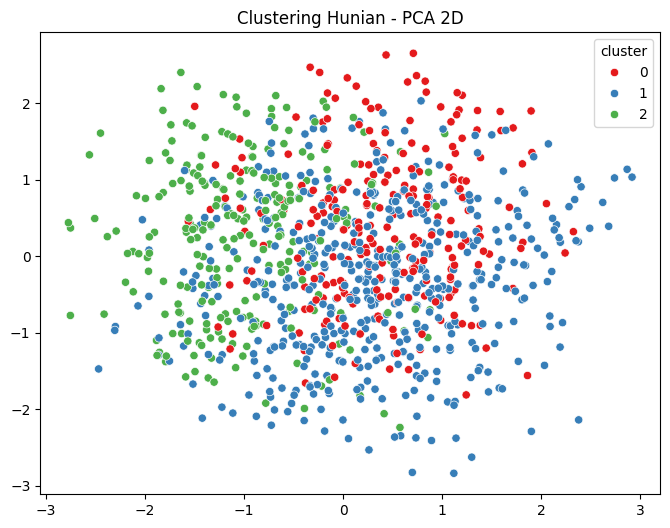

In [29]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_cluster["cluster"], palette="Set1")
plt.title("Clustering Hunian - PCA 2D")
plt.show()
# 1 layak huni, #Semi kumuh, 3 Kumuh

In [30]:
# Rata-rata tiap cluster
cluster_summary = df_cluster.groupby("cluster")[[
    "luas_lantai","jumlah_anggota_keluarga","jumlah_kamar_tidur"
]].mean()

print(cluster_summary)


         luas_lantai  jumlah_anggota_keluarga  jumlah_kamar_tidur
cluster                                                          
0          66.809129                 4.879668            3.004149
1          68.908911                 4.986139            2.912871
2          73.633858                 5.000000            2.889764


**Kluster rumah per keluarahan**

In [31]:
kelurahan_cluster = df_cluster.groupby(["kelurahan","cluster"]).size().reset_index(name="jumlah_rumah")
print(kelurahan_cluster.head(10))


         kelurahan  cluster  jumlah_rumah
0      Balai-Balai        0            17
1      Balai-Balai        1            48
2      Balai-Balai        2            16
3   Bukit Surungan        0            21
4   Bukit Surungan        1            35
5   Bukit Surungan        2            18
6       Ekor Lubuk        0            22
7       Ekor Lubuk        1            39
8       Ekor Lubuk        2            14
9  Guguk Malintang        0            17
